### Date: 2023-10-16
### Author: Jennifer Fortuny I Zhan
### Content: Project 2 Regression, Linear Regression

In this file I will perform linear regression to predict income levels based on our independent variables, namely:
- age
- education-num
- hours-per-week (of work)
- workclass
- occupation
The data has already bee standarised previously using standardscaler() (see 2023-10-05_jennifer_data_preparation.ipynb).

After an initial linear regression, I will introduce a regularisation parameter λ, and use 10-fold cross-validation to estimate the generalisation error for different values of λ.

Finally, I will analyse the linear model which shoes the lowest generalisation error, to understand how each feature impacts the predicted income level.

Workflow overview:
1. Loading the pre-processed data, double checking all the feature transformation are correctly implemented.
2. Introduce the regularisation parameter λ, use scikit-learn's built-in methods for 10-fold cross-validation. This will return the generalisation error for different values of λ.
3. Plot the generalisation errors against the λ values, visualise the optimal regulisation parameter.
4. Compare the model coefficients to understand the effect of individual features on the predicted income.

In [28]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for Linear Regression training and fitting
from sklearn.linear_model import LinearRegression
# for L2 regularisation (Ridge linear regression)
from sklearn.linear_model import RidgeCV, Ridge
# for calculating average generalisation error for each alpha, after L2 regularisation.
from sklearn.model_selection import cross_val_score

In [5]:
# Loading the csv files
dependent_test_df = pd.read_csv("../2023-10-05_jennifer_data_preparation/dependent_test.csv")
dependent_train_df = pd.read_csv("../2023-10-05_jennifer_data_preparation/dependent_train.csv")
independent_test_df = pd.read_csv("../2023-10-05_jennifer_data_preparation/independent_test.csv")
independent_train_df = pd.read_csv("../2023-10-05_jennifer_data_preparation/independent_train.csv")

To recap, our data set has the target variable "income", which is binary-coded as 0 or 1.

The predictor variables, i.e. features, include both continuous variables:
    - age
    - education-num
    - hours-per-week
and one-hot encoded categorical variables:
    - workclass_?
    - worlclass_Federal-gov
    - workclass_Local-gov...

The continous variables have been standarized.


In [6]:
# Checking the data was imported correctly
print(dependent_test_df.head())
print(dependent_train_df.head())
print(independent_train_df.head())
print(independent_test_df.head())

   income
0       0
1       0
2       1
3       0
4       0
   income
0       0
1       1
2       0
3       0
4       1
        age  education-num  hours-per-week  workclass_ ?  \
0 -0.596105      -1.436812        0.038178           0.0   
1  1.029636       1.854382        0.038178           0.0   
2 -0.209024       0.867024        0.038178           0.0   
3  0.255474      -0.120334        0.038178           0.0   
4  1.494133       0.867024        0.038178           0.0   

   workclass_ Federal-gov  workclass_ Local-gov  workclass_ Private  \
0                     0.0                   0.0                 1.0   
1                     1.0                   0.0                 0.0   
2                     1.0                   0.0                 0.0   
3                     0.0                   0.0                 1.0   
4                     0.0                   0.0                 1.0   

   workclass_ Self-emp-inc  workclass_ Self-emp-not-inc  workclass_ State-gov  \
0          

In [7]:
# Training the linear regression model.

# Creating an instance of the LinearRegression class
model = LinearRegression()

# Fitting the trainning data to the model
model.fit(independent_train_df, dependent_train_df)

LinearRegression()

In [21]:
# L2 regularisation (Ridge linear regression).

# Creating a range of lambda (alpha) values
alphas = np.logspace(-6, 6, 13)    # to get values rangeing from 10^-6 to 10^6.

# Initiate RidgeCV to perform 10-fold cross-validation
ridge = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the RidgeCV model
ridge.fit(independent_train_df, dependent_train_df)

# Find the average generalisation error for each alpha
# Using squeez to remove dimensions of size 1.
mean_errors = np.mean(np.squeeze(ridge.cv_values_), axis=0)

# Look for the optimal alpha value
optimal_alpha = ridge.alpha_

print(f"Optimal alpha: {optimal_alpha}")

Optimal alpha: 10.0


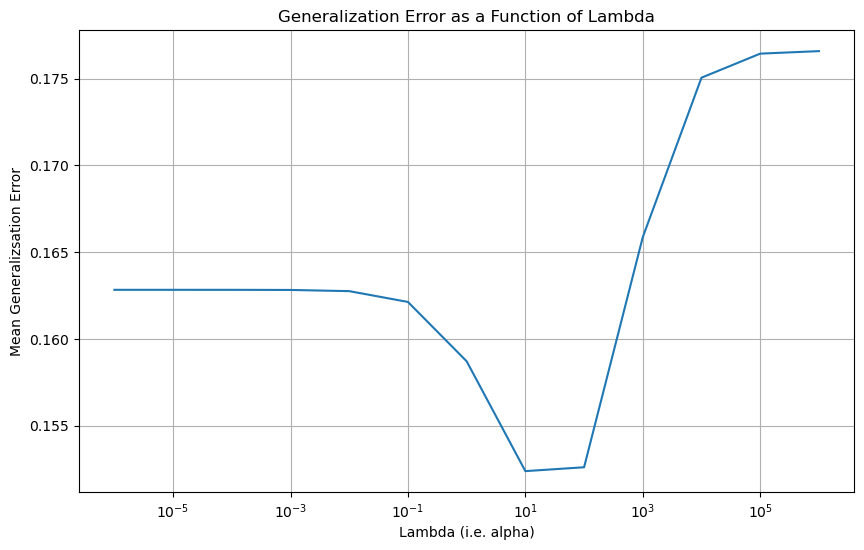

In [24]:
# Plotting the generalisation errors against lambda values
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_errors)    # log-scale used on x-axis
plt.xlabel("Lambda (i.e. alpha)")
plt.ylabel("Mean Generalizsation Error")
plt.title("Generalization Error as a Function of Lambda")
plt.grid(True)
plt.show()

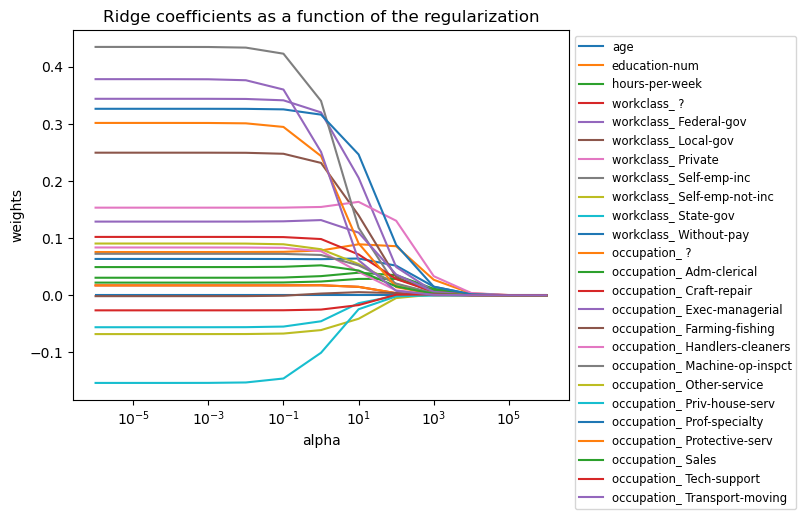

In [35]:
# Comparing the model coefficients to understand the effect of individual
# features on the predicted income.
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(independent_train_df, dependent_train_df)
    coefs.append(ridge.coef_)

ax = plt.gca()

features = independent_train_df.columns

for idx, feature in enumerate(features):
    ax.plot(alphas, np.array(np.squeeze(coefs))[:, idx], label=feature)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::1])  # reverse the axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.legend(loc="best", bbox_to_anchor=(1, 1), fontsize='small')  #Adding a legend
plt.axis("tight")
plt.show()

The plot shows how the model coefficients change as we vary the regularisation strength ('alpha').

In general, as alpha increases, the pentalty for large coefficients also increases. This decreases the absolute values of the coefficients.

Some coefficients flatten out sooner than others. This indicates that they reached their regularisation state. Coefficients that remain large, even as alpha increases, are likely to be more influential or significan predictors in the model. Coefficients that approach zero qucikly as alpha increases might not be as impactful.

We can infer which features(predictor variables) have the most signidicant impact on predicting the income of an individual.

The presence of many lines suggests that there are many features in our dataset, this is likely due to one-hot encoding of the categorical variable "workclass".

The next plot only displays features with a large absolute weight, as both large positive and large negative coefficients indicate a strong influence on the dependent variable.

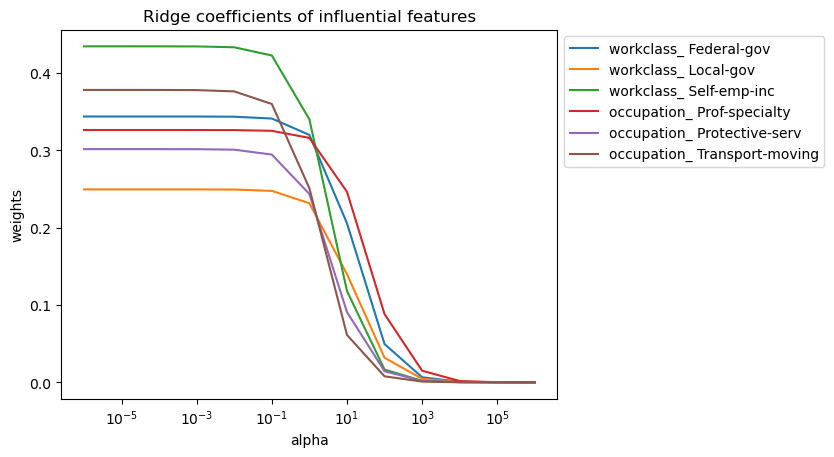

In [39]:
# Consider coefficients with the absolute magnitude of 0.2 to be significant, using this as the threshold.
threshold = 0.2

ax = plt.gca()

# For each feature, check its max coefficient magnitude across all alphas
for idx, feature in enumerate(features):
    max_coef_magnitude = np.max(np.abs(np.array(np.squeeze(coefs))[:, idx]))
    if max_coef_magnitude > threshold:
        ax.plot(alphas, np.array(np.squeeze(coefs))[:, idx], label=feature)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::1])
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients of influential features")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.axis("tight")
plt.show()

This plot suggests that:
- The feature "work_Self-emp-inc" has the strongest influence on predicted income. As its regulisation strength (alpha) changes, this feature consistenly shows the highest weight. This suggests being self-employed is one of the storngest predictors of income.
- Following that, the features "occupation_Transport-moving", "workclass_Federal-gov", "occupation_Prof-speciality" were also amongest the features with the greatest weight magnitudes.
